https://www.kaggle.com/code/lvishalraju/sentement-analysis-with-tweets-lstm-87-accuarcy/notebook

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Importing the packages**

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
import re
import nltk
from nltk.corpus import twitter_samples
import random
nltk.download('stopwords')
import string   
from tensorflow.keras.preprocessing.text import Tokenizer                        
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Loading the data**

In [ ]:
tweets=pd.read_csv("Twitter_Data.csv")

In [ ]:
tweets['clean_text']=tweets['clean_text'].astype('str')

In [ ]:
tweets.head(10)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


# **Dropping Nan Values**

In [ ]:
tweets=tweets.dropna()

# **Data Visualization**

In [ ]:
all_positive_tweets=tweets[tweets['category']==1]['clean_text']
all_neutral_tweets=tweets[tweets['category']==0]['clean_text']
all_negative_tweets=tweets[tweets['category']==-1]['clean_text']

# **Interpreting nature of tweet with length of the tweet**

In [ ]:
total_positive_words = []
for sentence in all_positive_tweets:
    total_positive_words.append(sentence.count(' '))
    
total_negative_words = []
for sentence in all_negative_tweets:
    total_negative_words.append(sentence.count(' '))

total_neutral_words = []
for sentence in all_neutral_tweets:
    total_neutral_words.append(sentence.count(' '))
    
import plotly.graph_objects as go
import numpy as np

x0 = np.array(total_positive_words)
x1 = np.array(total_negative_words)
x2 = np.array(total_neutral_words)

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, name = 'Positive'))
fig.add_trace(go.Histogram(x=x2, name = 'Neutral'))


# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=x1, name = 'Negative'))
fig.add_trace(go.Histogram(x=x2, name = 'Neutral'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, name = 'Positive'))
fig.add_trace(go.Histogram(x=x1, name = 'Negative'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

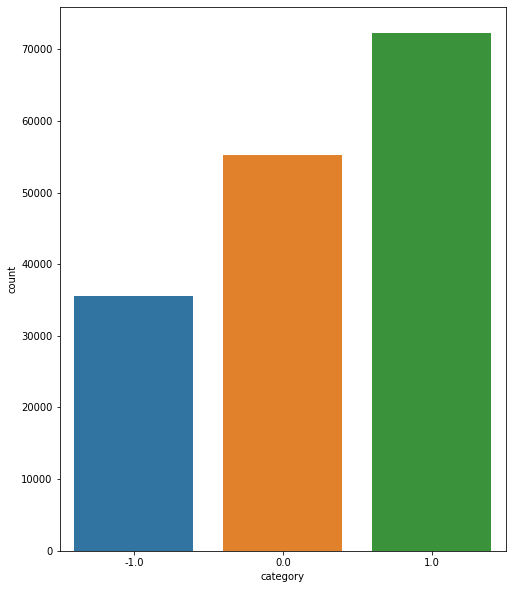

In [ ]:
plt.figure(figsize=(8,10))
sns.countplot(x=tweets['category'])

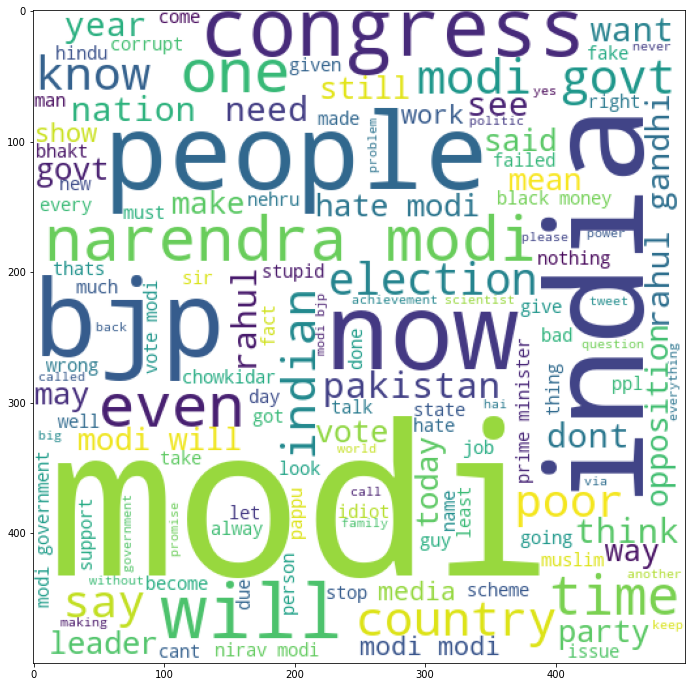

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
positive_wc = wc.generate(tweets[tweets['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(tweets[tweets['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(tweets[tweets['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.imshow(positive_wc)

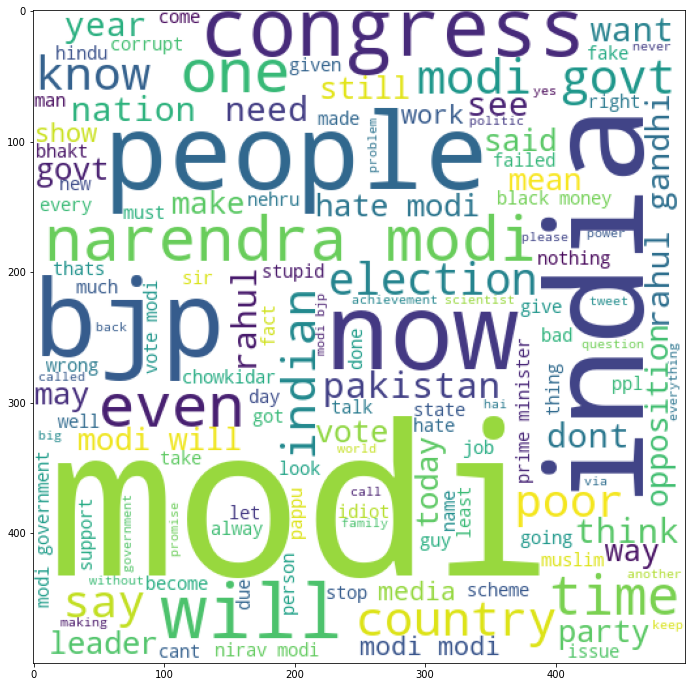

In [ ]:
plt.figure(figsize = (12, 12))
plt.imshow(neutral_wc)

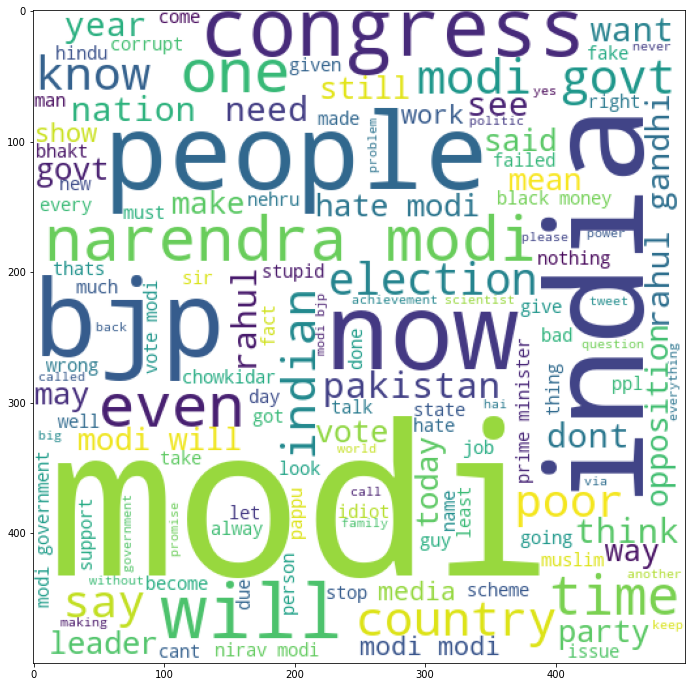

In [ ]:
plt.figure(figsize = (12, 12))
plt.imshow(negative_wc)

In [ ]:
tweets.isnull().sum()

clean_text    0
category      0
dtype: int64

# **Removing StopWords and Punctuations**

In [ ]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english') 

print('Stop words\n')
print(stopwords_english)

print('\nPunctuation\n')
print(string.punctuation)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [ ]:
tweets=tweets.dropna(axis=0)

In [ ]:
tweets.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
#Antes del stopword
tweets['clean_text'][0]

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [ ]:
# Removing Stopwords
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_english)]))

In [ ]:
tweets['clean_text'][0]

'modi promised “minimum government maximum governance” expected begin difficult job reforming state take years get justice state business exit psus temples'

In [ ]:
# removing punctuations
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
#Finalmente
tweets['clean_text'][0]

'modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state business exit psus temples'

# **Stemming The Words**

In [ ]:
stemmer = PorterStemmer() 
def stemming(word):
    list1=[]
    for i in word.split():
        list1.append(stemmer.stem(i))
    return ' '.join(list1)
    
tweets['clean_text'] = tweets['clean_text'].apply(lambda x:stemming(x))

In [ ]:
tweets['category'] = [2 if x == -1 else x for x in tweets['category']]

In [ ]:
tweets_2=tweets.copy()

In [ ]:
tweets_2

,clean_text,category
0,modi promis minimum govern maximum govern expe...,2.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0
...,...,...
162975,456 crore paid neerav modi recov congress lead...,2.0
162976,dear rss terrorist payal gawar modi kill 1000 ...,2.0
162977,cover interact forum left,0.0
162978,big project came india modi dream project happ...,0.0


In [ ]:
tweet_largo = []
for sentence in tweets_2['clean_text']:
    resultado = len(sentence.split())
    tweet_largo.append(resultado)
print(tweet_largo)
print(np.shape(tweet_largo))
print(max(tweet_largo))    

[21, 6, 13, 19, 10, 6, 10, 9, 21, 3, 25, 17, 5, 17, 15, 13, 4, 12, 22, 12, 21, 19, 8, 24, 11, 18, 21, 5, 17, 7, 11, 14, 23, 21, 14, 1, 7, 19, 23, 9, 8, 14, 7, 24, 28, 22, 28, 3, 28, 10, 12, 10, 13, 21, 22, 24, 4, 2, 20, 26, 5, 7, 13, 16, 14, 20, 10, 19, 7, 6, 13, 15, 16, 26, 15, 7, 6, 17, 16, 12, 9, 14, 19, 5, 7, 24, 11, 28, 18, 22, 17, 11, 6, 11, 7, 22, 5, 11, 18, 34, 8, 27, 29, 16, 15, 14, 11, 8, 18, 23, 6, 7, 12, 27, 8, 8, 23, 30, 3, 7, 12, 12, 4, 12, 11, 12, 29, 2, 3, 28, 15, 10, 13, 14, 3, 28, 13, 8, 5, 5, 1, 8, 16, 24, 2, 4, 20, 24, 1, 15, 9, 13, 11, 10, 21, 13, 19, 20, 18, 14, 9, 10, 15, 14, 13, 10, 7, 13, 23, 17, 10, 7, 21, 11, 30, 12, 18, 13, 3, 10, 28, 11, 24, 9, 9, 5, 9, 29, 4, 11, 18, 6, 1, 18, 8, 26, 7, 12, 7, 8, 14, 22, 4, 24, 31, 23, 16, 8, 15, 8, 25, 22, 11, 23, 9, 17, 2, 4, 25, 11, 20, 26, 11, 12, 4, 13, 28, 4, 22, 8, 10, 21, 22, 15, 9, 23, 22, 10, 30, 27, 11, 26, 24, 5, 29, 29, 13, 6, 15, 14, 11, 6, 28, 10, 26, 5, 7, 5, 5, 20, 14, 10, 30, 16, 2, 12, 24, 34, 9, 15, 1, 

# **Tokenizing the words**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets.clean_text)
word_index = tokenizer.word_index

In [ ]:

word_index

{'modi': 1,
 'india': 2,
 'bjp': 3,
 'peopl': 4,
 'like': 5,
 'congress': 6,
 'elect': 7,
 'vote': 8,
 'narendra': 9,
 'say': 10,
 'nation': 11,
 'govt': 12,
 'one': 13,
 'indian': 14,
 'year': 15,
 'time': 16,
 'countri': 17,
 'dont': 18,
 'give': 19,
 'want': 20,
 'get': 21,
 'know': 22,
 'rahul': 23,
 'make': 24,
 'support': 25,
 'govern': 26,
 'even': 27,
 'take': 28,
 'also': 29,
 'come': 30,
 'power': 31,
 'work': 32,
 'parti': 33,
 'gandhi': 34,
 'minist': 35,
 'polit': 36,
 'think': 37,
 'need': 38,
 'credit': 39,
 'leader': 40,
 'see': 41,
 'good': 42,
 'ask': 43,
 'space': 44,
 'would': 45,
 'money': 46,
 'said': 47,
 'hai': 48,
 'win': 49,
 'pakistan': 50,
 'done': 51,
 'chowkidar': 52,
 'sir': 53,
 'promis': 54,
 'back': 55,
 'job': 56,
 'prime': 57,
 'everi': 58,
 'day': 59,
 'opposit': 60,
 'announc': 61,
 'scientist': 62,
 'via': 63,
 'today': 64,
 'achiev': 65,
 'never': 66,
 '2019': 67,
 'use': 68,
 'live': 69,
 'mani': 70,
 'poor': 71,
 'call': 72,
 'world': 73,
 'new

In [ ]:
vocab_size = len(word_index)+1
vocab_size

88555

# **Padding the tweets**

In [ ]:
# padding the tokenized sequences to same length
max_length = 43
lines = pad_sequences(tokenizer.texts_to_sequences(tweets.clean_text),maxlen = max_length)

In [ ]:
tweets.clean_text = lines.tolist()

In [ ]:
tweets.category.value_counts()

1.0    72250
0.0    55213
2.0    35510
Name: category, dtype: int64

In [ ]:
tweets.head()


,clean_text,category
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


In [ ]:
np.shape(tweets)

(162973, 2)

In [ ]:
tweets.isnull().sum()

clean_text    0
category      0
dtype: int64

# **Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(tweets['clean_text'],tweets['category'],test_size=0.1,random_state=101)
X_train = np.vstack(X_train.values)
y_train = np.vstack(y_train.values)

X_val = np.vstack(X_test.values)
y_val = np.vstack(y_test.values)

# **Data Modelling**

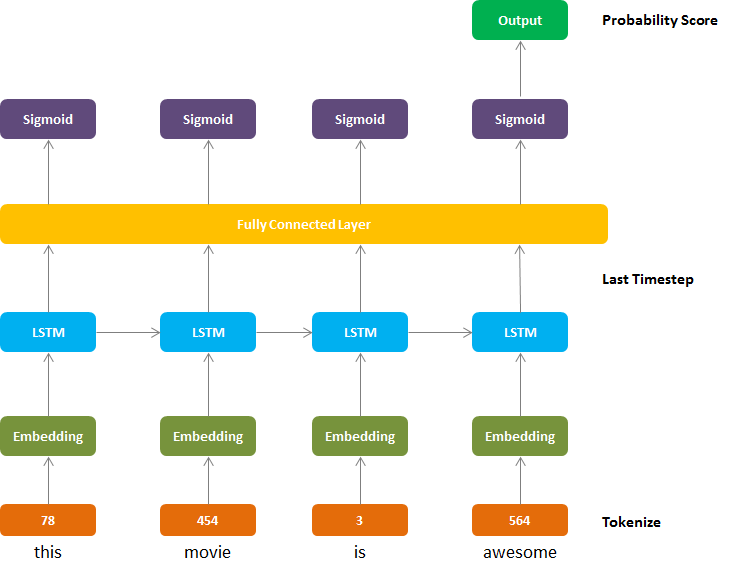

# **Sequential Modelling**

In [ ]:
model = tf.keras.Sequential()

# Input layer
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=vocab_size,output_dim=15,trainable=True))

# LSTM layer
model.add(LSTM(64, activation='relu'))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 15)          1328325   
                                                                 
 lstm_4 (LSTM)               (None, 64)                20480     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,353,160
Trainable params: 1,353,160
Non-trainable params: 0
_________________________________________________________________


# **Adding Optimizer,loss function and Training the Model**





Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



144/144 [==============================] - 16s 98ms/step - loss: 0.0865 - accuracy: 0.9719 - val_loss: 0.4835 - val_accuracy: 0.9037
Epoch 2/20
144/144 [==============================] - 14s 97ms/step - loss: 0.0717 - accuracy: 0.9766 - val_loss: 0.5068 - val_accuracy: 0.8979
Epoch 3/20
144/144 [==============================] - 14s 98ms/step - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.5705 - val_accuracy: 0.8929
Epoch 4/20
144/144 [==============================] - 14s 98ms/step - loss: 0.0586 - accuracy: 0.9808 - val_loss: 0.6522 - val_accuracy: 0.8886
Epoch 5/20
144/144 [==============================] - 14s 96ms/step - loss: 0.0552 - accuracy: 0.9818 - val_loss: 0.6781 - val_accuracy: 0.8839
Epoch 6/20
144/144 [==============================] - 14s 99ms/step - loss: 0.0519 - accuracy: 0.9827 - val_loss: 0.7304 - val_accuracy: 0.8798
Epoch 7/20
144/144 [==============================] - 14s 98ms/step - loss: 0.0481 - accuracy: 0.9835 - val_loss: 0.7547 - val_accuracy: 0.8773
Epo

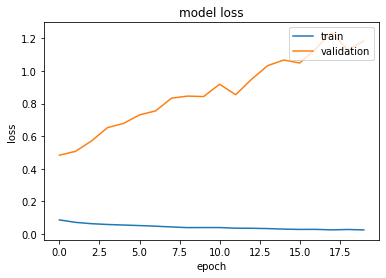

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=512,
                    verbose=1,shuffle=True,validation_split=0.5)
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# **Accuracy and Loss of Test data**

In [ ]:
predictions = model.predict(X_val)
print(history.history)

{'loss': [0.08654359728097916, 0.071695476770401, 0.0634140595793724, 0.05861705169081688, 0.055168021470308304, 0.051918596029281616, 0.048096366226673126, 0.04351285472512245, 0.03939592465758324, 0.0398406982421875, 0.039713457226753235, 0.035904817283153534, 0.03529995679855347, 0.03343668207526207, 0.030184099450707436, 0.028298240154981613, 0.02863142266869545, 0.025514597073197365, 0.0279088132083416, 0.025246858596801758], 'accuracy': [0.971883237361908, 0.9766420722007751, 0.9791919589042664, 0.9807736873626709, 0.9818099737167358, 0.9826690554618835, 0.9835280776023865, 0.9853280186653137, 0.9866506457328796, 0.9869370460510254, 0.9869233965873718, 0.9877415299415588, 0.9879733324050903, 0.9887369275093079, 0.9896232485771179, 0.9902641177177429, 0.9900323152542114, 0.9912731647491455, 0.9901277422904968, 0.9914913177490234], 'val_loss': [0.48346754908561707, 0.5067586898803711, 0.5705378651618958, 0.6521757245063782, 0.6780819296836853, 0.7303984761238098, 0.7546523213386536

# **Model Evaluvation**

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_val, y_val, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
128/128 [==============================] - 1s 8ms/step - loss: 2.0448 - accuracy: 0.7940
test loss, test acc: [2.044759511947632, 0.7940238118171692]
